In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
pandas 0.23.4
torch 1.4.0


In [35]:
import torch

import os, wget
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [36]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [37]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [38]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

In [39]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [40]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [41]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [42]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')

In [43]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,50,53,59,70,75,82,114,147,177
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,502,511,581,639,639,701,773,839,825,878
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,150,160,178,178,200,212,226,243,266
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,99,117,129,149,149,197,238,428,566,673


In [44]:
# df = df[df['Country/Region'] == 'China']

In [45]:
df = df.iloc[:, 4:]

In [46]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Cumulative daily cases')

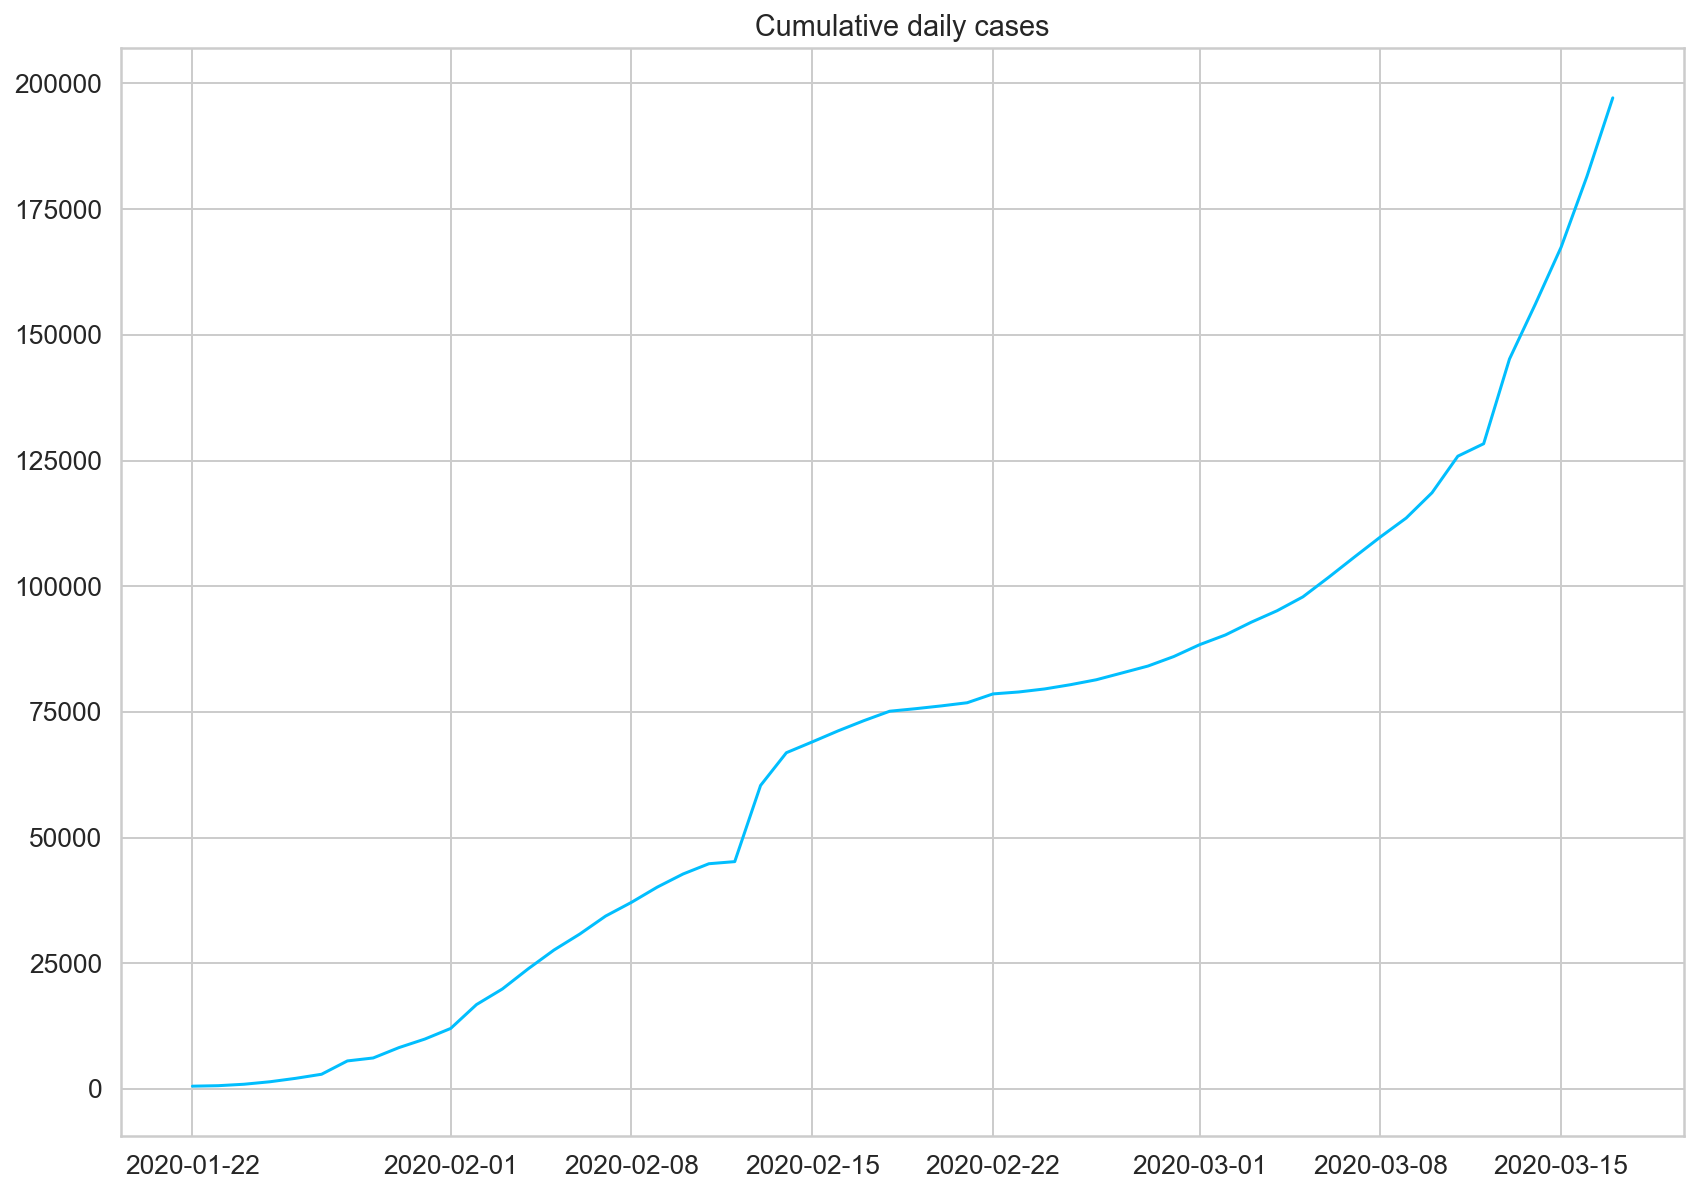

In [47]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases")

In [48]:
cumulative_cases = daily_cases
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

Text(0.5, 1.0, 'Daily cases')

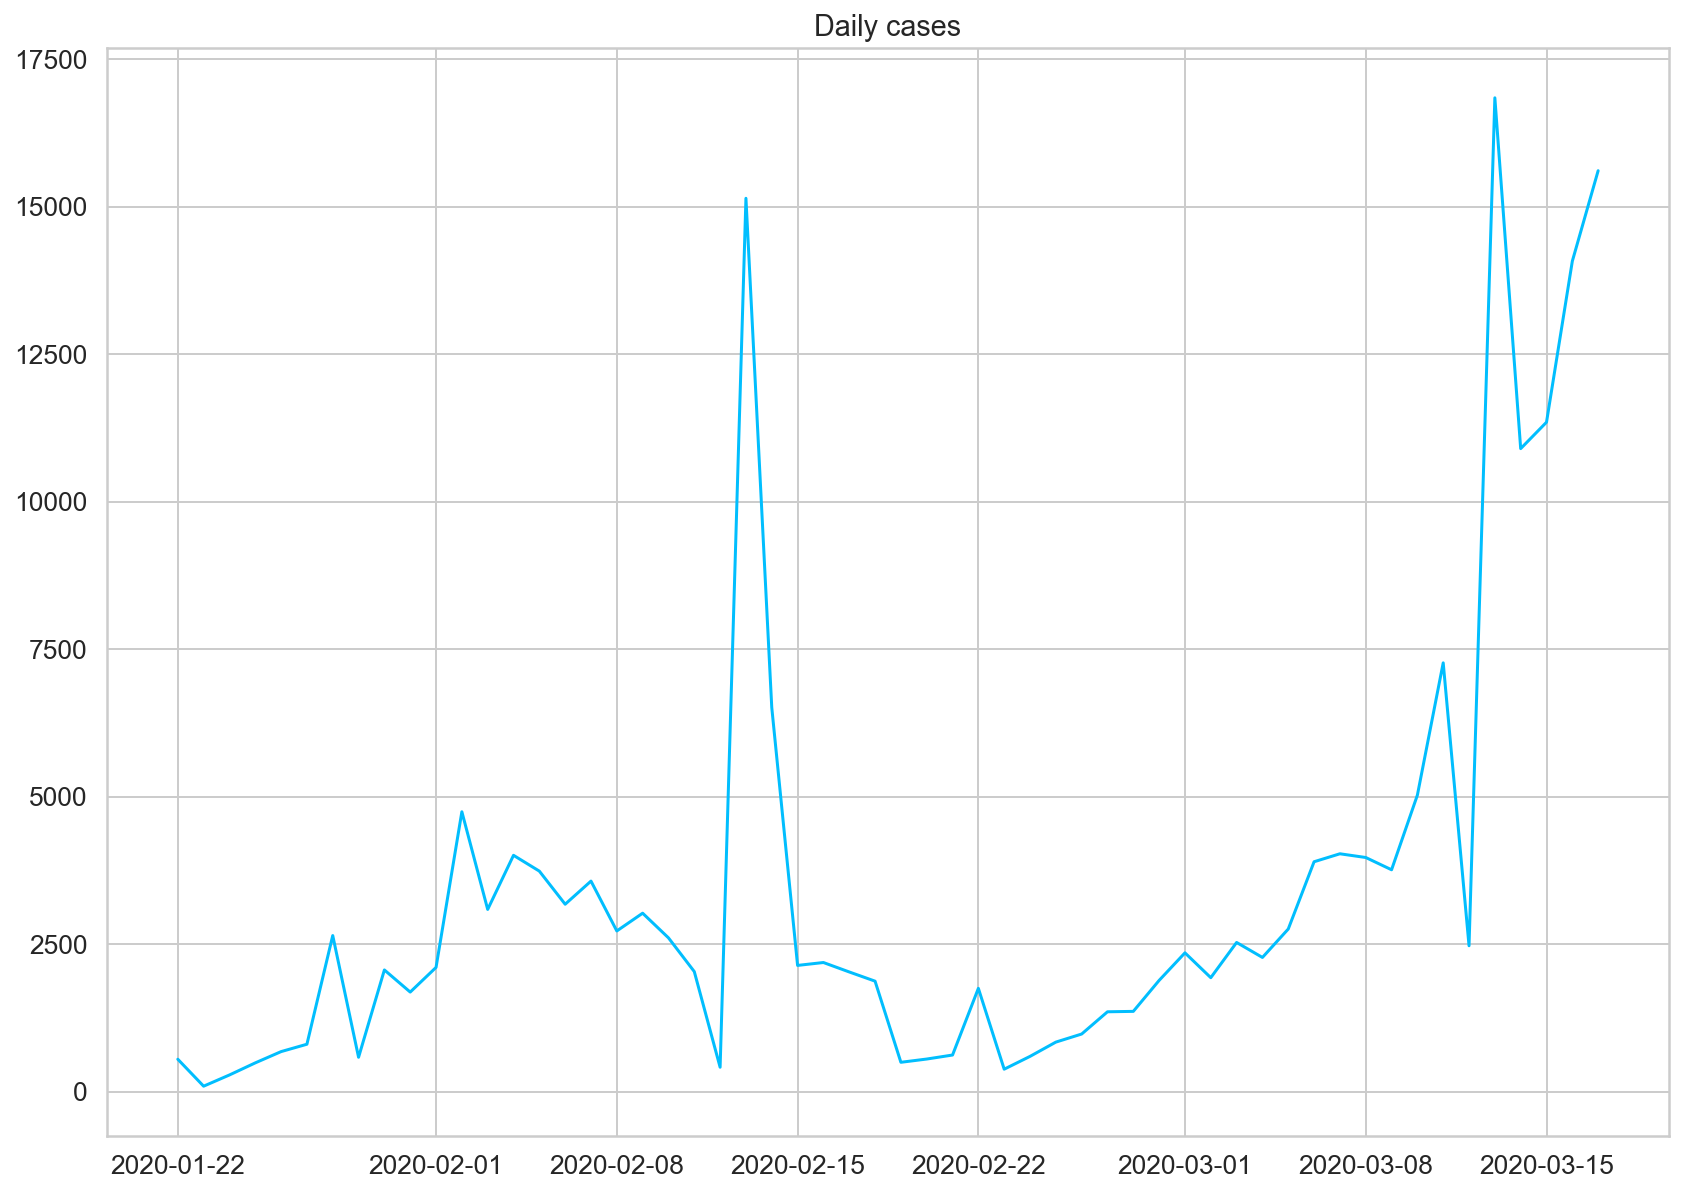

In [49]:
plt.plot(daily_cases)
plt.title("Daily cases")

In [50]:
cumulative_cases.shape

(56,)

In [82]:
test_data_size = 7

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(49,)

In [83]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [84]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [85]:
seq_length = 3
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [86]:
X_train.shape

torch.Size([45, 3, 1])

In [87]:
X_train[:2]

tensor([[[0.0304],
         [0.0000],
         [0.0126]],

        [[0.0000],
         [0.0126],
         [0.0262]]])

In [88]:
y_train.shape

torch.Size([45, 1])

In [89]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.6
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [90]:
def train_model(model, train_data, train_labels, test_data=None,test_labels=None):
    
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)
  num_epochs = 300

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [91]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 2.617490530014038 test loss: 2.073901891708374
Epoch 10 train loss: 1.4224121570587158 test loss: 1.582446813583374
Epoch 20 train loss: 1.0871539115905762 test loss: 1.2720775604248047
Epoch 30 train loss: 1.0883779525756836 test loss: 1.2029998302459717
Epoch 40 train loss: 1.0925891399383545 test loss: 1.2801377773284912
Epoch 50 train loss: 1.0941829681396484 test loss: 1.2983825206756592
Epoch 60 train loss: 1.0645986795425415 test loss: 1.2735847234725952
Epoch 70 train loss: 1.0763338804244995 test loss: 1.2583826780319214
Epoch 80 train loss: 1.0854847431182861 test loss: 1.2870537042617798
Epoch 90 train loss: 1.0904226303100586 test loss: 1.276534080505371
Epoch 100 train loss: 1.0810229778289795 test loss: 1.269089698791504
Epoch 110 train loss: 1.0873908996582031 test loss: 1.275750756263733
Epoch 120 train loss: 1.0738084316253662 test loss: 1.2682929039001465
Epoch 130 train loss: 1.0824698209762573 test loss: 1.280642032623291
Epoch 140 train loss: 1.

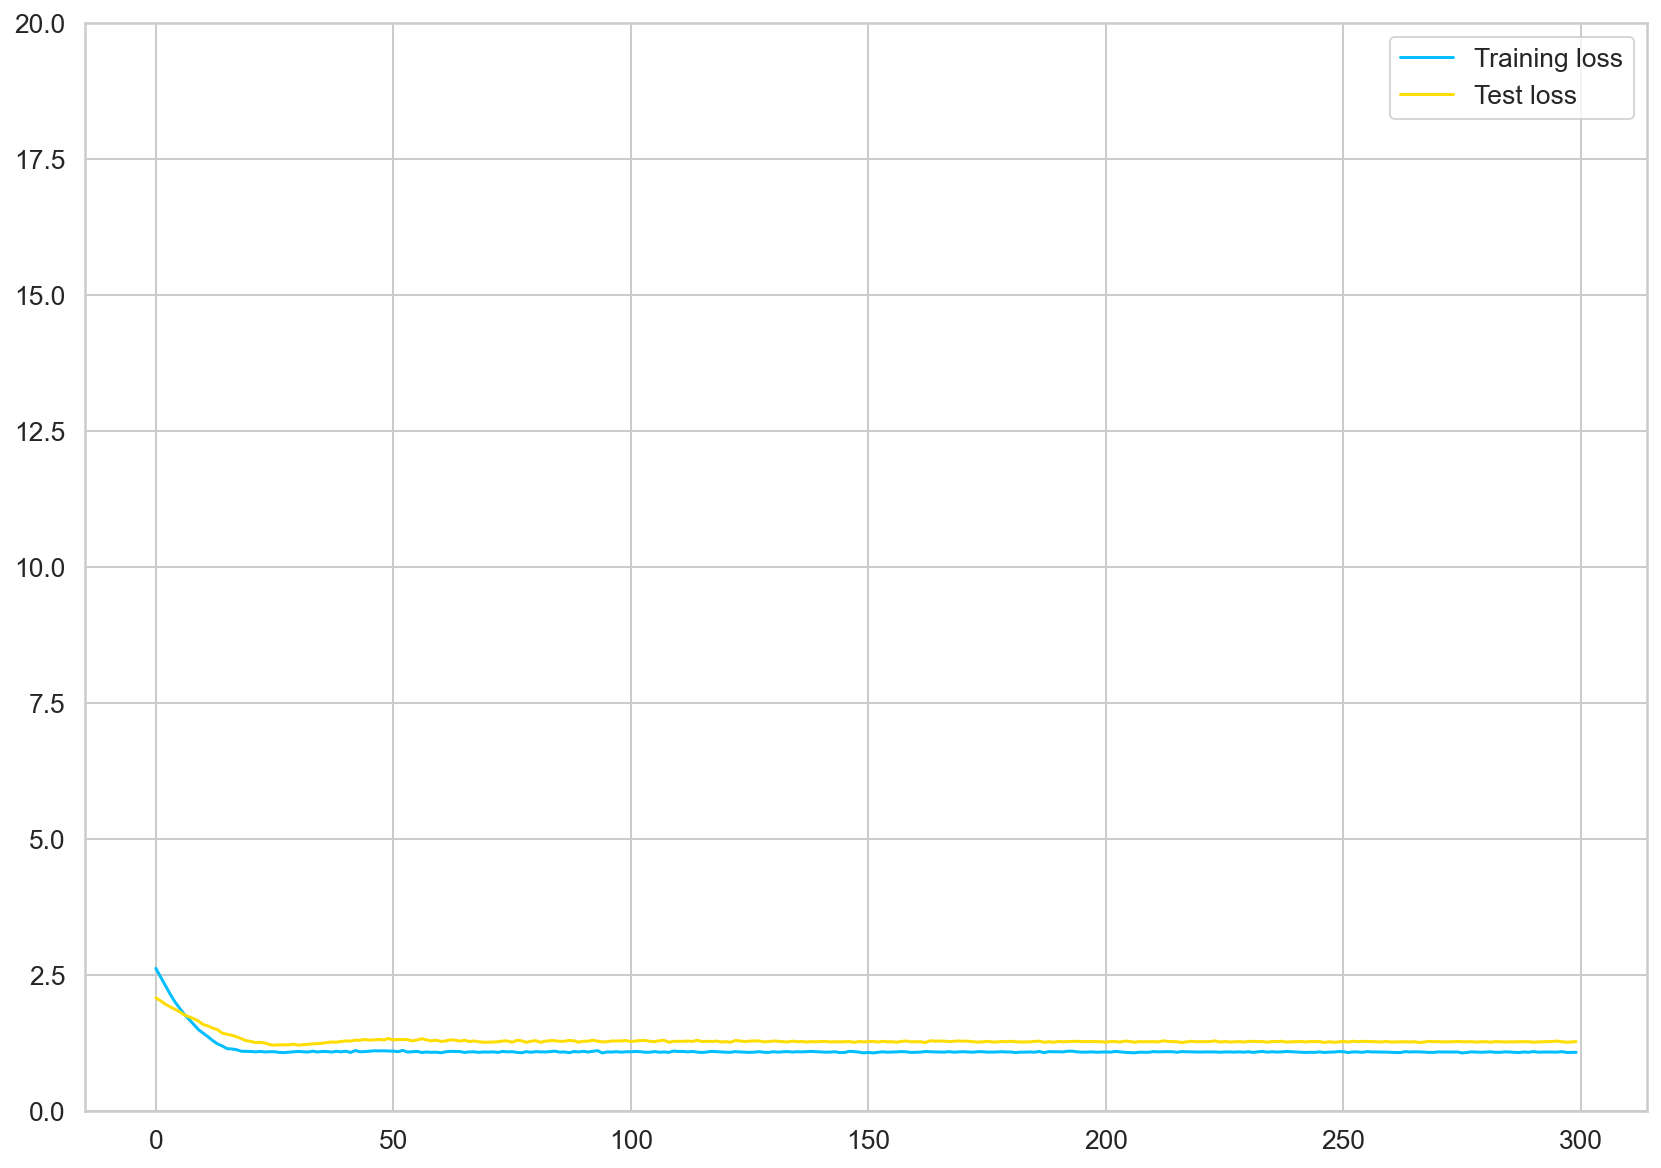

In [92]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 20))
plt.legend()

In [93]:
with torch.no_grad():
    test_seq = X_test[:1]
    print(test_seq)
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        print(test_seq)

tensor([[[0.4768],
         [0.1582],
         [1.1132]]])
tensor([[[0.1582],
         [1.1132],
         [0.1546]]])
tensor([[[1.1132],
         [0.1546],
         [0.1552]]])
tensor([[[0.1546],
         [0.1552],
         [0.1555]]])


In [94]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [95]:
true_cases

array([10904., 11352., 14082.], dtype=float32)

In [96]:
predicted_cases

array([2424.43426432, 2432.85296677, 2438.02456434])

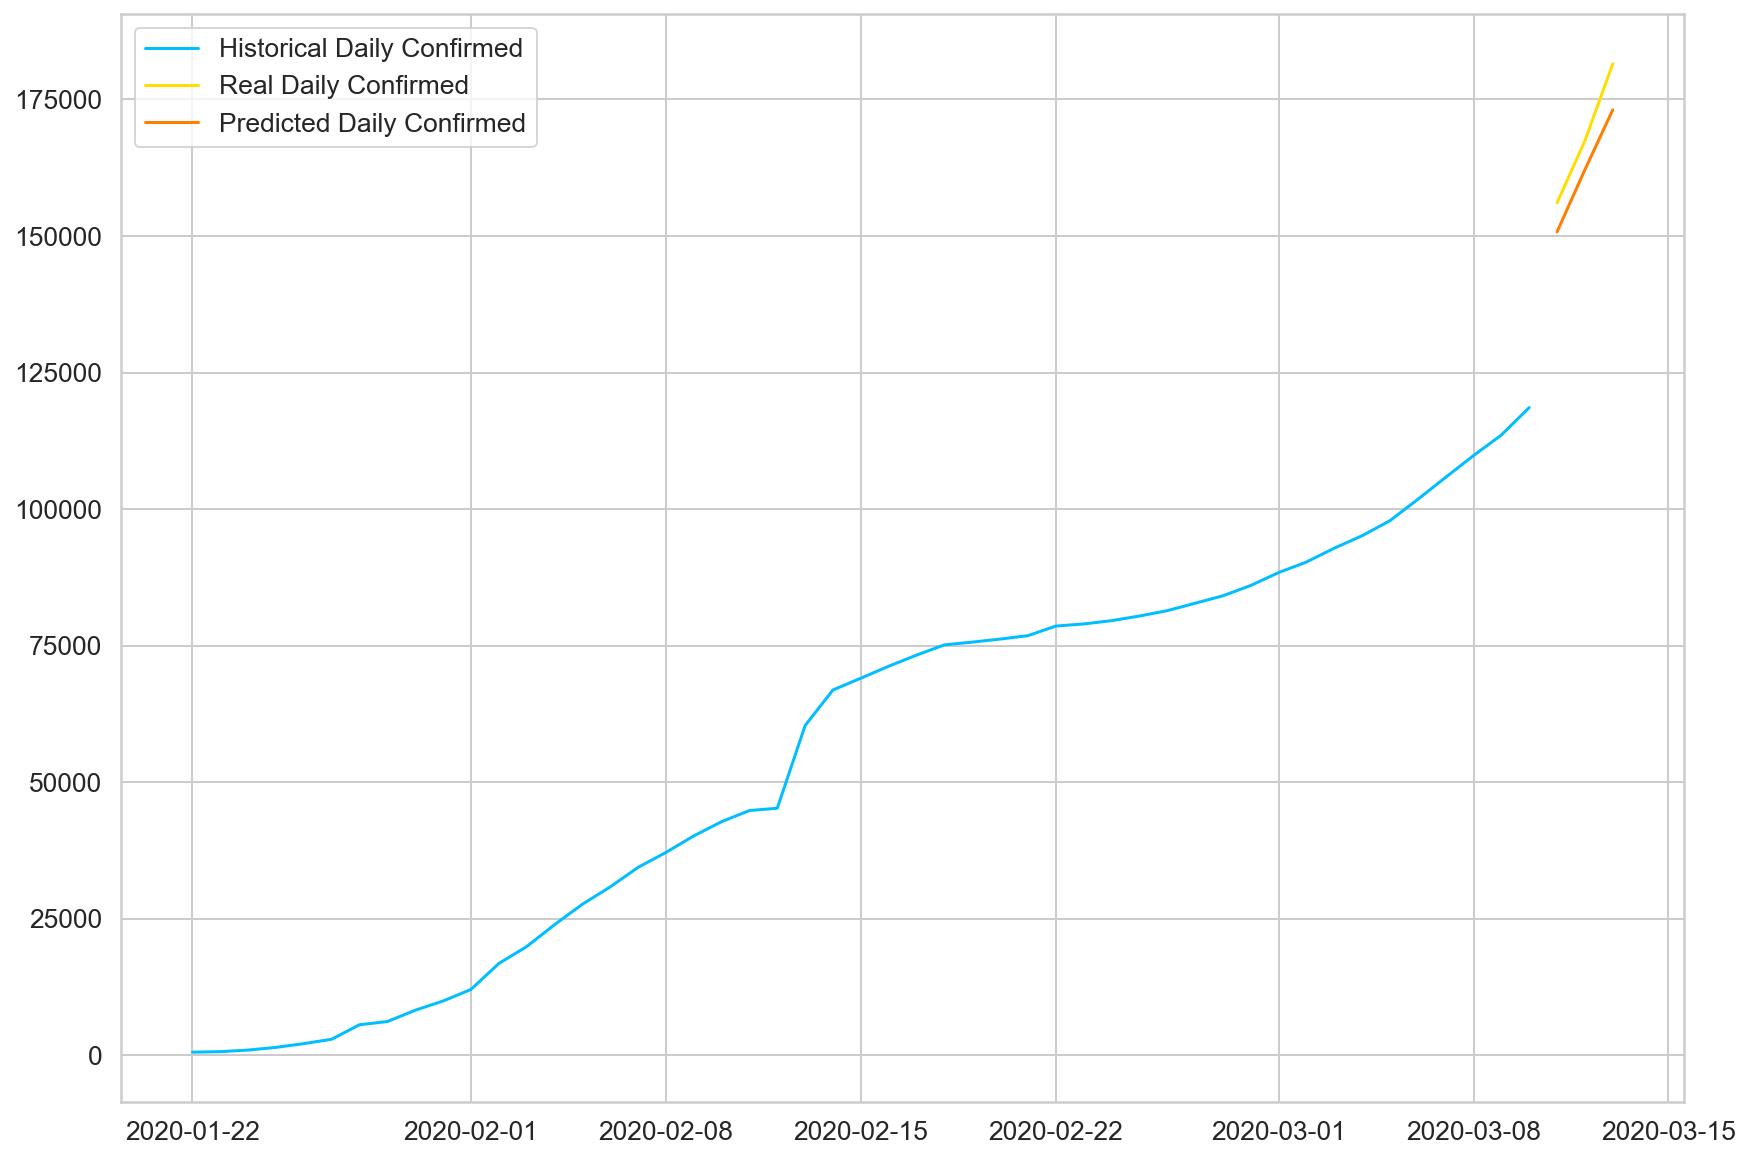

In [81]:
plt.plot(
  cumulative_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()